In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('TechStockDataForModelNoOutliers.csv')

In [4]:
df.head()

,RSI_10,HighCloseVolAvg_1,HighCloseVolAvg_5,HighCloseVolAvg_20,SP_change_1,SP_change_3,SP_change_5,SP_change_10,SP_change_Target,Target
0,46.323328,0.015513,0.041756,0.016885,0.038357,-0.030344,-0.143710,-0.063970,-0.015172,No
1,41.138215,0.061768,0.044094,0.019856,-0.033747,-0.065821,-0.157811,-0.114834,0.018063,No
2,39.239633,0.028839,0.036692,0.020849,-0.013304,-0.007321,-0.079286,-0.116161,0.031607,Yes
3,45.537478,0.004941,0.033150,0.021056,0.029126,-0.016990,-0.048544,-0.081896,0.001560,No
4,45.871443,0.028475,0.027907,0.021834,0.001558,0.017743,0.023542,-0.116843,-0.029514,No


In [5]:
df.shape

(51211, 10)

A reminder that the "Target" column is yes if SP_Change >= 0.0225 and No otherwise.

In [6]:
df['Target'].value_counts()

No     26192
Yes    25019
Name: Target, dtype: int64

### Train Test Split

To avoid any data leakage, I will do my train-test-split now.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(df, test_size=0.1, random_state=42)

### EDA on train set

I will now perform EDA on train set.

In [9]:
train.head()

,RSI_10,HighCloseVolAvg_1,HighCloseVolAvg_5,HighCloseVolAvg_20,SP_change_1,SP_change_3,SP_change_5,SP_change_10,SP_change_Target,Target
42448,42.409992,0.013065,0.011625,0.013884,-0.004523,0.019598,0.025628,-0.037688,0.019598,No
42029,69.719460,0.002874,0.027113,0.024579,0.023467,0.045977,0.090517,0.169061,0.031609,Yes
31599,69.204996,0.023893,0.019681,0.023036,0.039111,0.049003,0.086973,0.070309,0.105616,Yes
19557,51.365222,0.004933,0.014092,0.012958,0.012580,0.033054,0.016280,-0.018747,0.074741,Yes
45195,70.692268,0.025818,0.024667,0.021748,0.000901,0.027920,0.015611,0.065746,-0.016812,No


In [10]:
train['Target'].value_counts()

No     23527
Yes    22562
Name: Target, dtype: int64

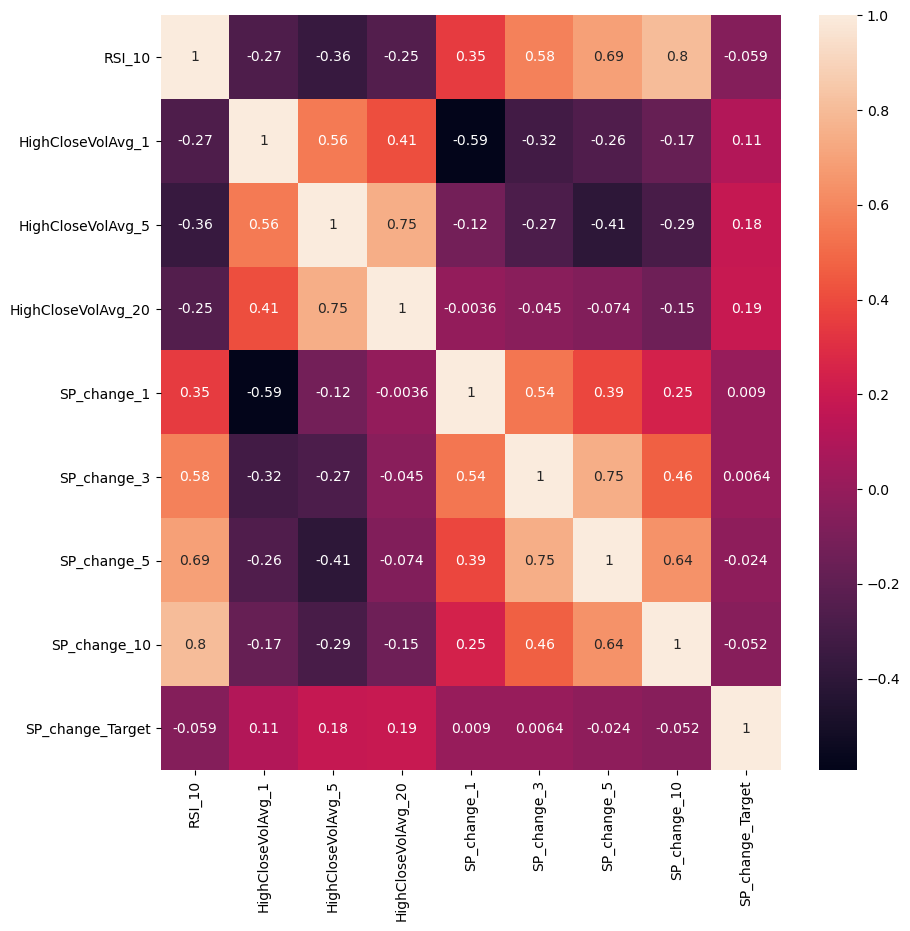

In [11]:
plt.figure(figsize=(10,10), dpi=100)

sns.heatmap(data=train.corr(), annot=True);

In [12]:
train.corr()['SP_change_Target'].sort_values(ascending=False)[1:]

HighCloseVolAvg_20    0.186922
HighCloseVolAvg_5     0.180734
HighCloseVolAvg_1     0.107365
SP_change_1           0.008990
SP_change_3           0.006351
SP_change_5          -0.024074
SP_change_10         -0.052131
RSI_10               -0.058694
Name: SP_change_Target, dtype: float64

While none are highly correlated, the SP_change_1 and SP_change_3 features seem to be very lowly correlated compared to the rest.

### Boxplots

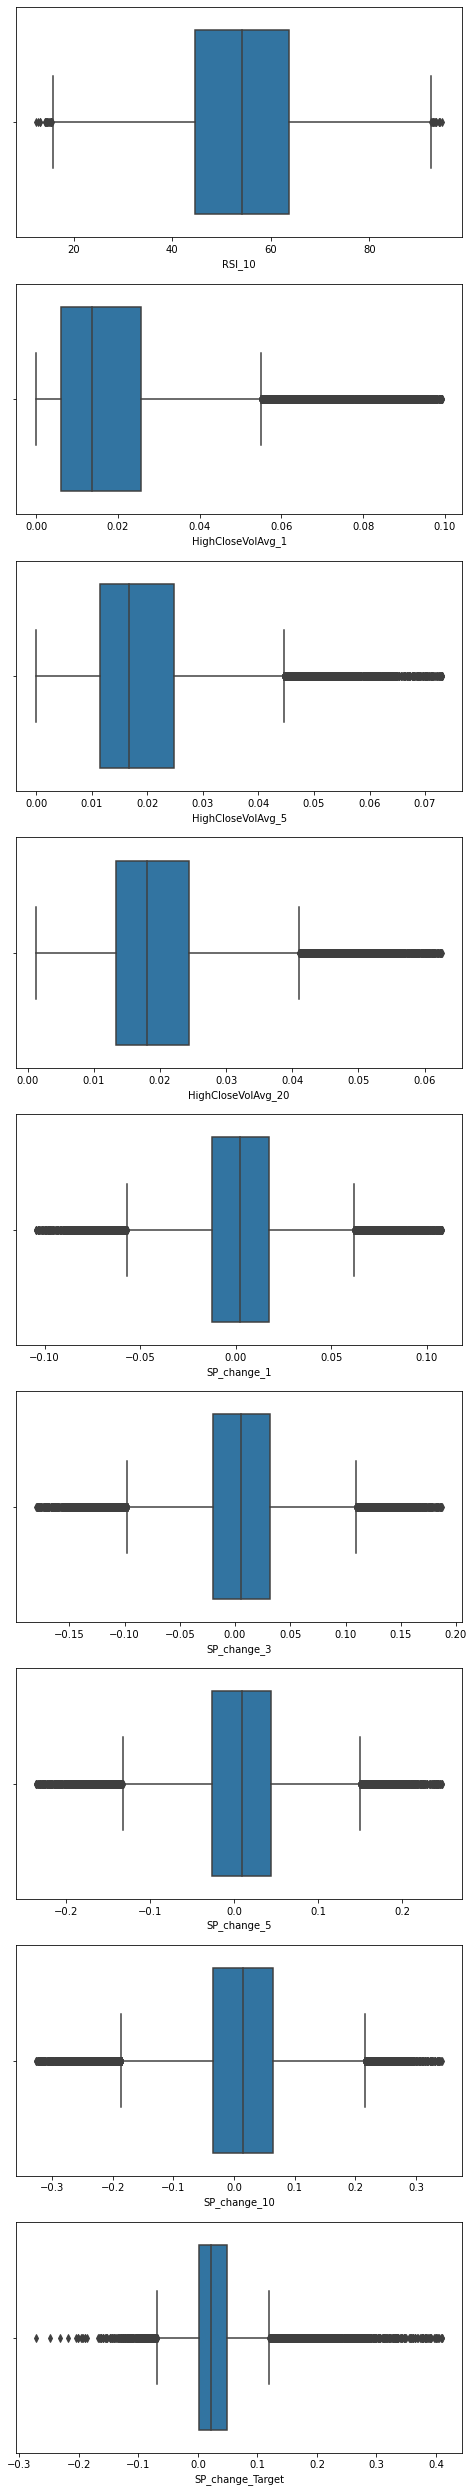

In [13]:
features = train.select_dtypes(include='number').columns

N = len(features)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(8, 5*N))

counter = 0

for feat in features:
    sns.boxplot(data=train, x=feat, ax=ax[counter])
    counter += 1
    

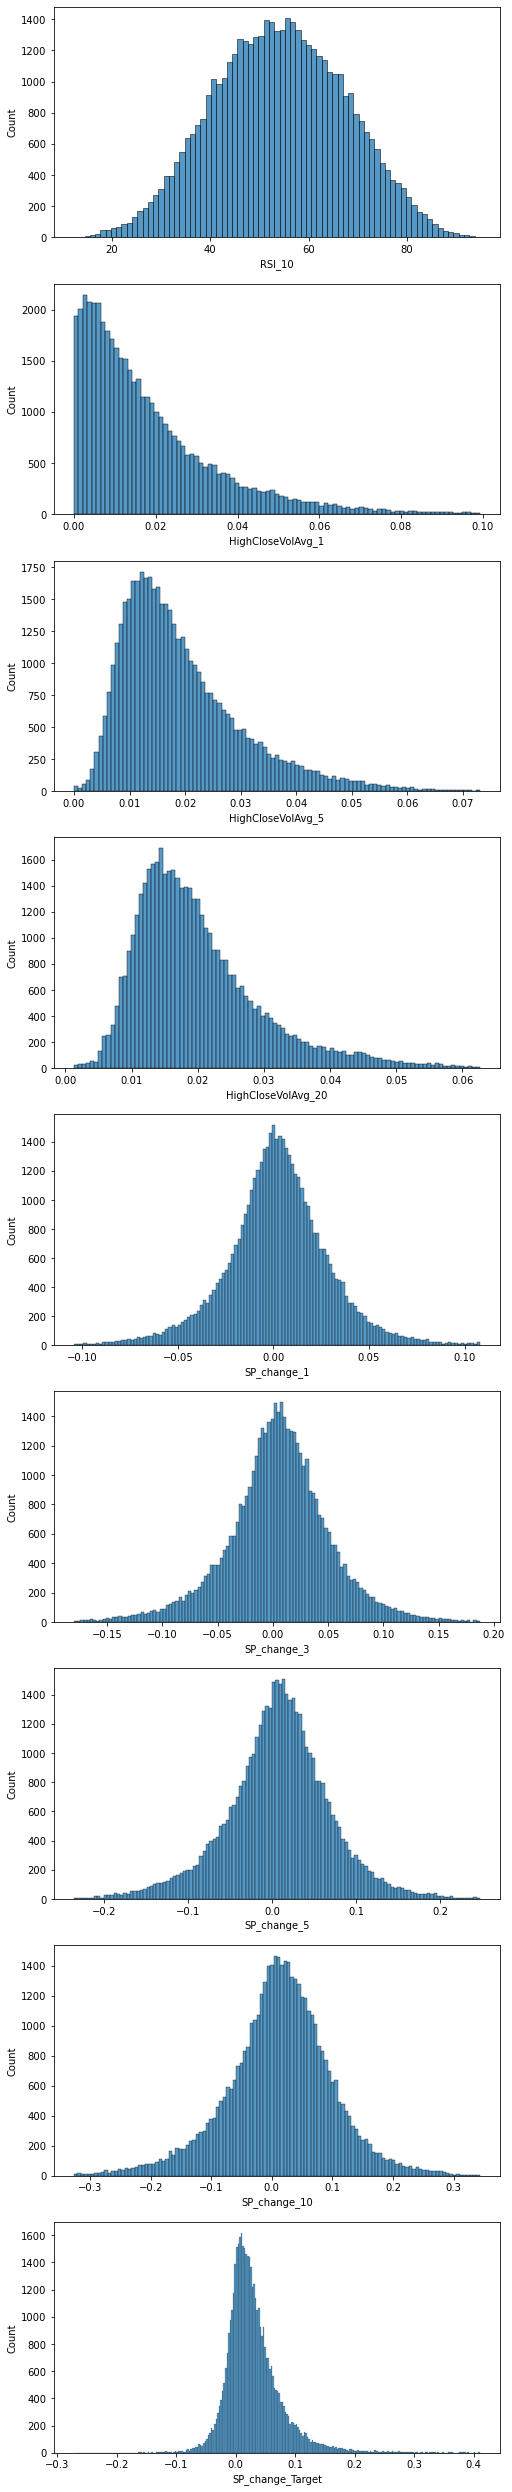

In [14]:
features = train.select_dtypes(include='number').columns

N = len(features)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(8, 5*N))

counter = 0

for feat in features:
    sns.histplot(data=train, x=feat, ax=ax[counter])
    counter += 1

With the outliers removed, all the distributions look good. The HighCloseVolAvg categories are one-tailed since they must be positive by definition.

I want to see now how they compare to the target.

### SP_change_Target

I first want to explore the numerical target category.

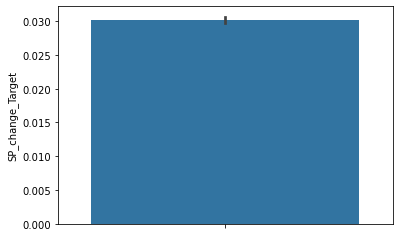

In [15]:
sns.barplot(data=train, y='SP_change_Target');

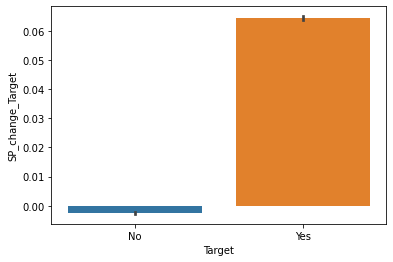

In [16]:
sns.barplot(data=train, y='SP_change_Target', x='Target');

Above we can clearly see the importance of predicting "Yes" instead of "No". By random choice, we could expect to see a 3% increase in SP_change_Target. However, predicting "Yes" correctly would give an expected increase of roughly 6% whereas a prediction of "No" gives a slightly negative (~0.3%) change.

Note that the Target column is balanced.

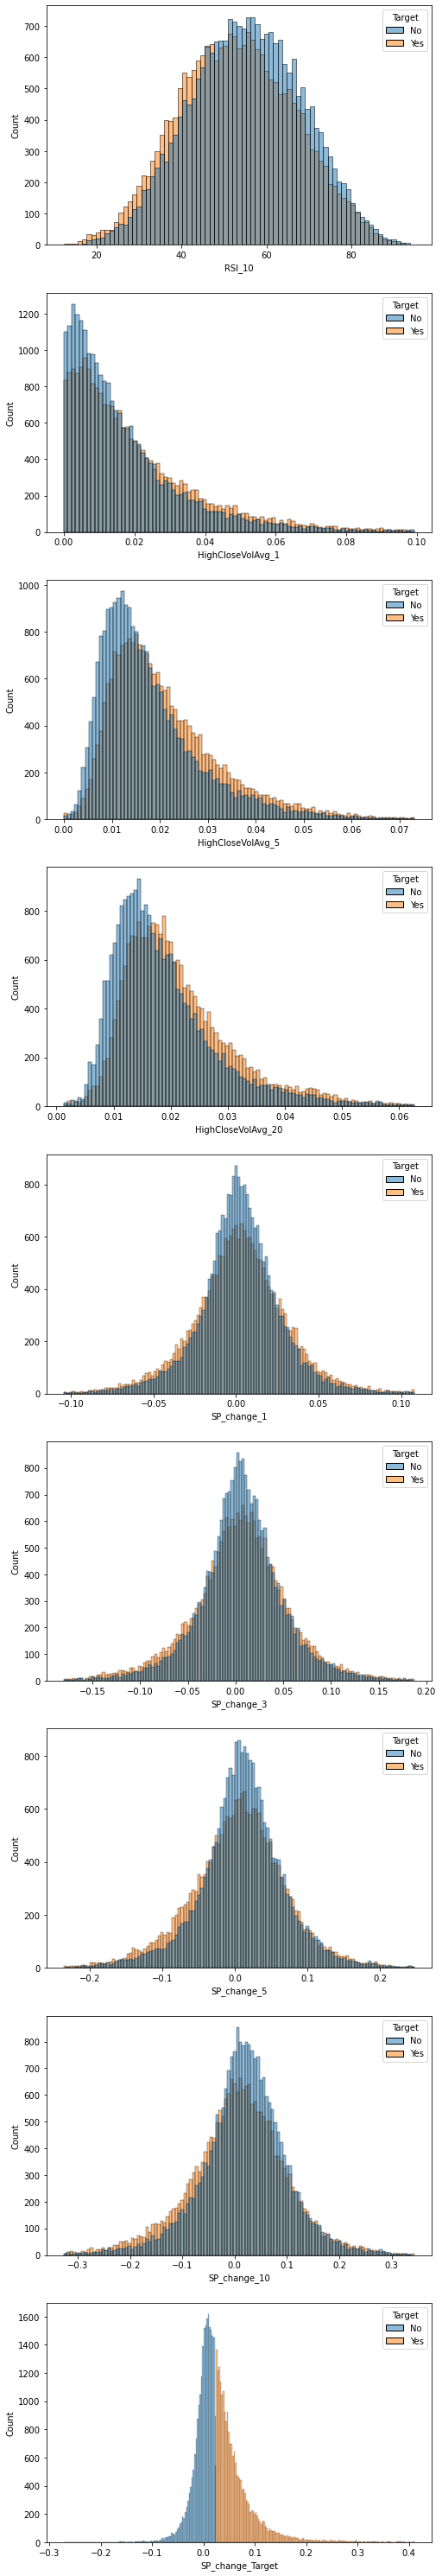

In [17]:
features = train.select_dtypes(include='number').columns

N = len(features)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(8, 6*N))

counter = 0

for feat in features:
    sns.histplot(data=train, x=feat, ax=ax[counter], hue='Target')
    counter += 1

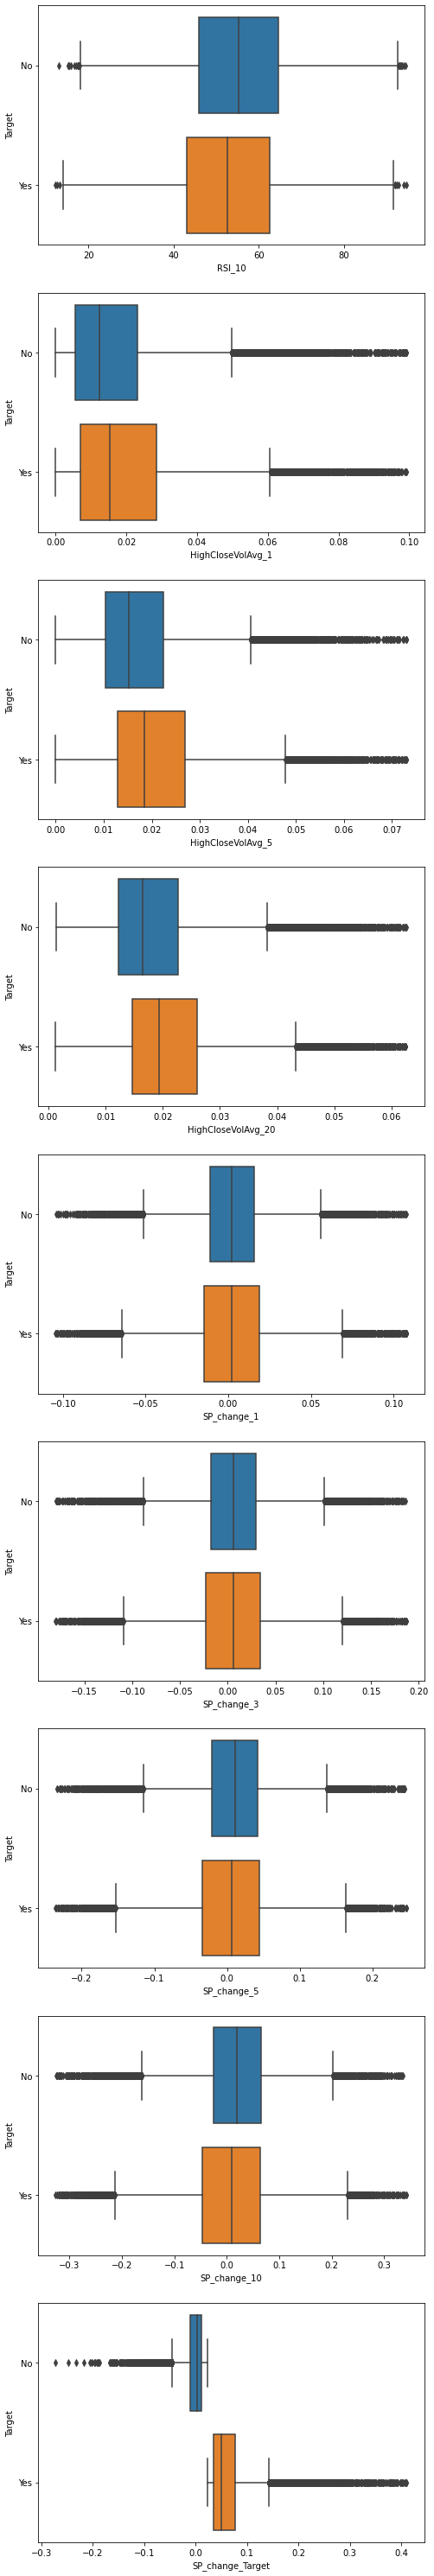

In [18]:
features = train.select_dtypes(include='number').columns

N = len(features)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(8, 6*N))

counter = 0

for feat in features:
    sns.boxplot(data=train, x=feat, ax=ax[counter], y='Target')
    counter += 1
    

### RSI 

I will now look at the RSI is related to the target in more detail.

Above we saw the RSI_10 category had majority "Yes" around RSI < 40 mark. I will use this to create a binning for the RSI category.

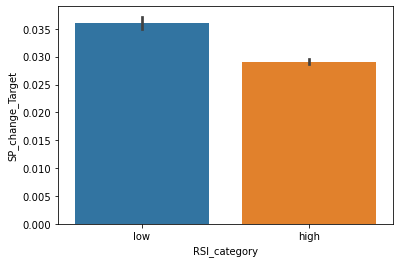

In [19]:
# RSI below 40

temp = train.copy(deep=True)

temp['RSI_category'] = pd.cut(temp['RSI_10'], bins=[0, 40, 100], labels=['low', 'high'])


sns.barplot(data=temp, x='RSI_category', y='SP_change_Target');

In [20]:
temp['RSI_category'].value_counts()

high    38963
low      7126
Name: RSI_category, dtype: int64

As we can see, if the RSI < 40, there is an expected gain of around 3.7% compared to about 2.8% for RSI > 40.

In order for a model to be worth running, it should have a mean of greater than 3.7% when predicting "Yes" on the target.

We can also see there is plenty of "Low" RSI as well (15-20%), so it would not be hard to find on a daily occurence.

### Volatilities

The next set of features I would like to look at is the daily volatility averages.

The above histogram for the volatilities showed that, when the volatility is above ~0.03, the majority of predictions go to "Yes". I will use this to create bins.

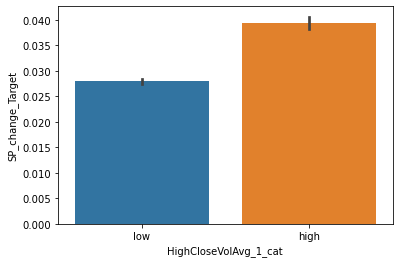

In [21]:
threshold = 0.03

temp['HighCloseVolAvg_1_cat'] = pd.cut(temp['HighCloseVolAvg_1'], bins=[-1, threshold, 1], labels=['low', 'high'])

sns.barplot(data=temp, x='HighCloseVolAvg_1_cat', y='SP_change_Target');

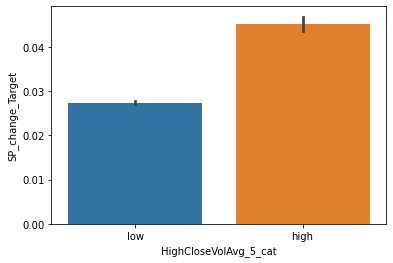

In [22]:
temp['HighCloseVolAvg_5_cat'] = pd.cut(temp['HighCloseVolAvg_5'], bins=[-1, threshold, 1], labels=['low', 'high'])

sns.barplot(data=temp, x='HighCloseVolAvg_5_cat', y='SP_change_Target');

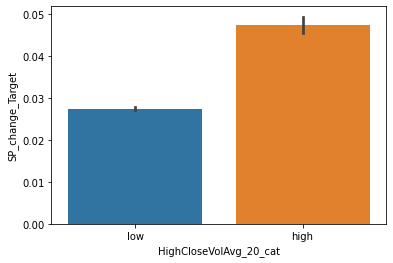

In [23]:
temp['HighCloseVolAvg_20_cat'] = pd.cut(temp['HighCloseVolAvg_20'], bins=[-1, threshold, 1], labels=['low', 'high'])

sns.barplot(data=temp, x='HighCloseVolAvg_20_cat', y='SP_change_Target');

In [24]:
temp['HighCloseVolAvg_1_cat'].value_counts()

low     36989
high     9100
Name: HighCloseVolAvg_1_cat, dtype: int64

In [25]:
temp['HighCloseVolAvg_5_cat'].value_counts()

low     38918
high     7171
Name: HighCloseVolAvg_5_cat, dtype: int64

In [26]:
temp['HighCloseVolAvg_20_cat'].value_counts()

low     39808
high     6281
Name: HighCloseVolAvg_20_cat, dtype: int64

As we can see above, the higher the volatility average, the more likely it is to see a yes vs a no for the target. Just looking at the "high" (>0.03) for the HighCloseVolAvg_20 feature, we expect to see ~4.7% increase.

Notice that these features, like RSI, occur roughly 15-20% of the time.

I will now see how these created categories pair together at predicting SP_change.

### Volumes

I initially added features based on ratios of average volume over a certain amount of days, but none of them were able to offer any insight, so I have removed them.

### SP_changes

I will now look at SP_changes.

Based on the histograms above, a moderate change (between -0.05 and 0.05) tended to having a more predominate "No", whereas the more extreme cases had a slightly bias towards "Yes".

I will create a binning for these categories based on those.

In [31]:
sp_change_idx = np.where(temp.columns.str.contains('SP_change_[0-9]')==True)
sp_change_cats = temp.columns[sp_change_idx]

for cat in sp_change_cats:
    temp[f'{cat}_cat'] = pd.cut(temp[cat], bins=[-1, -0.05, 0.05, 1], labels=['negative', 'moderate', 'positive'])

In [32]:
temp.head()

,RSI_10,HighCloseVolAvg_1,HighCloseVolAvg_5,HighCloseVolAvg_20,SP_change_1,SP_change_3,SP_change_5,SP_change_10,SP_change_Target,Target,RSI_category,HighCloseVolAvg_1_cat,HighCloseVolAvg_5_cat,HighCloseVolAvg_20_cat,SP_change_1_cat,SP_change_3_cat,SP_change_5_cat,SP_change_10_cat
42448,42.409992,0.013065,0.011625,0.013884,-0.004523,0.019598,0.025628,-0.037688,0.019598,No,high,low,low,low,moderate,moderate,moderate,moderate
42029,69.719460,0.002874,0.027113,0.024579,0.023467,0.045977,0.090517,0.169061,0.031609,Yes,high,low,low,low,moderate,moderate,positive,positive
31599,69.204996,0.023893,0.019681,0.023036,0.039111,0.049003,0.086973,0.070309,0.105616,Yes,high,low,low,low,moderate,moderate,positive,positive
19557,51.365222,0.004933,0.014092,0.012958,0.012580,0.033054,0.016280,-0.018747,0.074741,Yes,high,low,low,low,moderate,moderate,moderate,moderate
45195,70.692268,0.025818,0.024667,0.021748,0.000901,0.027920,0.015611,0.065746,-0.016812,No,high,low,low,low,moderate,moderate,moderate,positive


In [33]:
sp_change_idx = np.where(temp.columns.str.contains('SP_change_[0-9]+_cat')==True)
sp_change_cats = temp.columns[sp_change_idx]

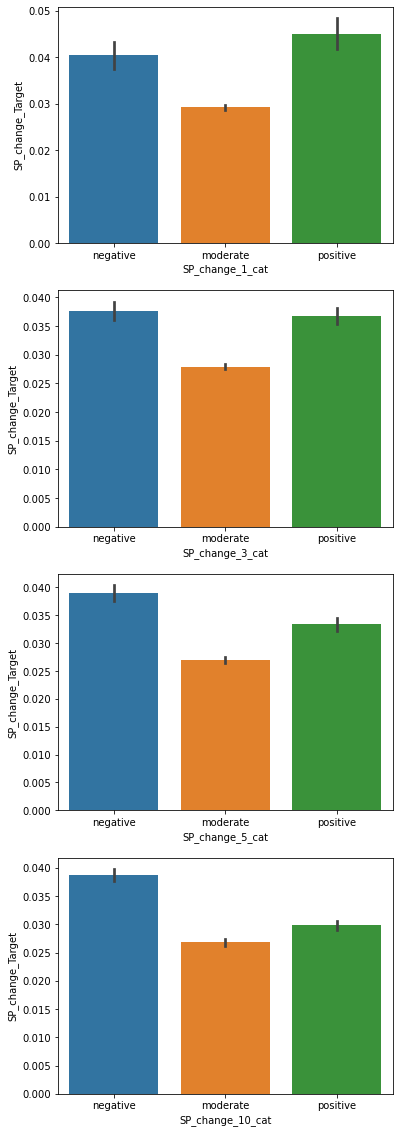

In [34]:
N = len(sp_change_cats)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(6, 5*N))

counter = 0

for i in sp_change_cats:
    sns.barplot(data=temp, x=i, y='SP_change_Target', ax=ax[counter])
    counter += 1

plt.show()

Of interest here is that the moderate is always the lowest, but as the number of days increases, the higher SP_change_Target is for negative vs positive.

In the analysis above, I feel as though the Volume features do not offer much insight directly. I do want to see how the picture compares when two features are done together.

In [35]:
from scipy.special import comb

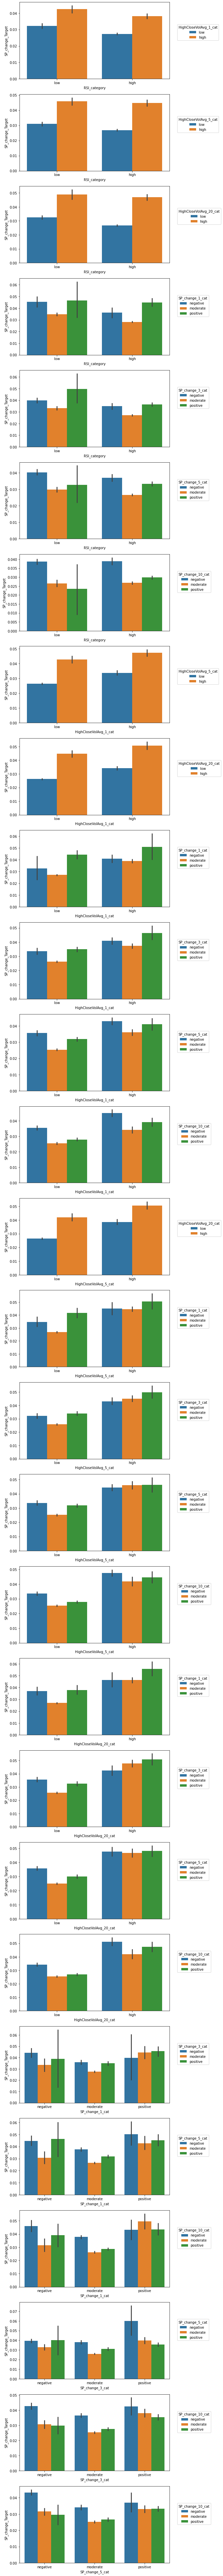

In [36]:
cat_feats = temp.dtypes[temp.dtypes=='category'].index

N = len(cat_feats)

k = comb(N, 2, exact=True)

counter = 0

fig, ax = plt.subplots(nrows=k, figsize=(8, 5*k))

for i in range(N-1):
    j = i + 1
    while j < N:
        sns.barplot(data=temp, x=cat_feats[i], hue=cat_feats[j], y='SP_change_Target', ax=ax[counter])
        ax[counter].legend(loc=(1.05, 0.5), title=cat_feats[j])
        j += 1
        counter += 1
        
plt.show()

Overall, we can see from the above pictures that the volume categories do not seem to add any insight. The last thing I will do is run a simple RandomForestRegressor to get feature importance.

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, plot_confusion_matrix, classification_report

In [38]:
X = temp.select_dtypes(include='category')
y = temp['Target']

X_dummies = pd.get_dummies(X)

In [39]:
X.isnull().sum()

RSI_category              0
HighCloseVolAvg_1_cat     0
HighCloseVolAvg_5_cat     0
HighCloseVolAvg_20_cat    0
SP_change_1_cat           0
SP_change_3_cat           0
SP_change_5_cat           0
SP_change_10_cat          0
dtype: int64

In [40]:
model = RandomForestClassifier()

custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label='Yes')

params = {'n_estimators': [50, 100, 250],
          'max_depth': [2, 4, 6]}

grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=custom_scorer, verbose=2, return_train_score=True)

grid.fit(X_dummies, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=2, n_estimators=250; total time=   1.3s
[CV] END ......................max_depth=2, n_est

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True,
             scoring=make_scorer(precision_score, pos_label=Yes), verbose=2)

In [41]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score', ascending=True)[['mean_test_score', 'mean_train_score']]

,mean_test_score,mean_train_score
2,0.585566,0.585698
1,0.584415,0.586264
0,0.583093,0.584056
3,0.573768,0.576173
4,0.572974,0.575203
5,0.572784,0.576477
6,0.569601,0.575935
8,0.569434,0.575264
7,0.569399,0.575525


As we can see, from the validation set, the data was not overfitting as the test and train scores are virtually the same.

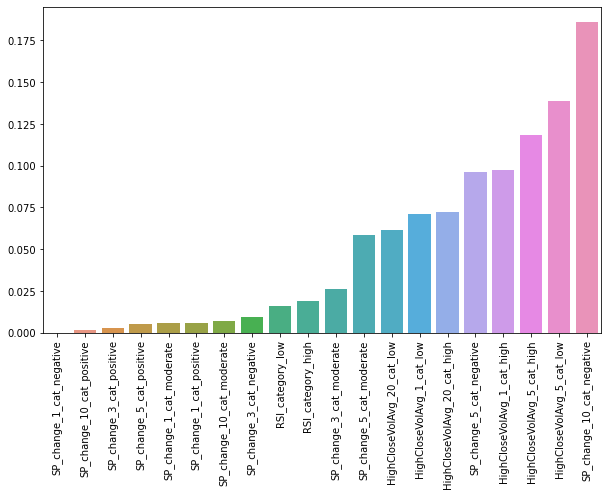

In [42]:
feats = grid.best_estimator_.feature_importances_

feats_ser = pd.Series(index=X_dummies.columns, data=feats).sort_values(ascending=True)

plt.figure(figsize=(10,6))
sns.barplot(x=feats_ser.index, y=feats_ser.values)

plt.xticks(rotation=90);

The feature importance shows that mostly what we knew, that the volume categories do not seem to add anything helpful.

I also note here that SP_change_1 does not add much either. I think it is worth keeping the remaining though.

In [43]:
preds = grid.predict(X_dummies)
probs = grid.predict_proba(X_dummies)[:, 1]

temp['Prediction'] = preds
temp['Probability'] = probs

In [44]:
results = temp[['SP_change_Target', 'Prediction', 'Probability']]

<AxesSubplot:xlabel='Prediction', ylabel='SP_change_Target'>

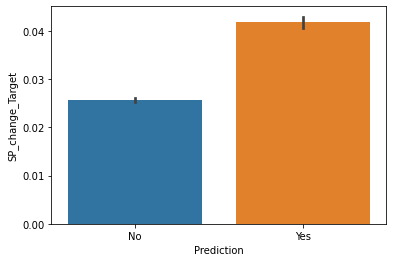

In [45]:
sns.barplot(data=results, x='Prediction', y='SP_change_Target')

In [46]:
results['Probability'].describe()

count    46089.000000
mean         0.489667
std          0.043230
min          0.455456
25%          0.455456
50%          0.467141
75%          0.506316
max          0.617010
Name: Probability, dtype: float64

All the probabilities are between 0.45 and 0.62. I will graph the probabilities with their increases to see how increasing the probability threshold changes the average SP_change_Target.

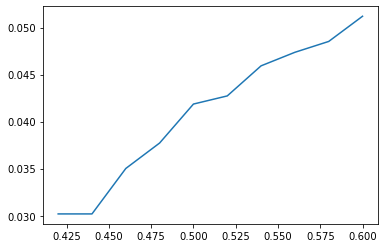

In [47]:
prob_thresh = np.linspace(0.42, 0.6, 10)

avgs = []
counts = []
for prob in prob_thresh:
    ser = results[results['Probability']>=prob]['SP_change_Target']
    avg = ser.mean()
    avgs.append(avg)
    count = ser.shape[0]
    counts.append((np.round(prob, 2), count))
    

prob_ser = pd.Series(index=prob_thresh, data=avgs)

plt.plot(prob_ser.index, prob_ser.values);

In [48]:
counts

[(0.42, 46089),
 (0.44, 46089),
 (0.46, 27979),
 (0.48, 19113),
 (0.5, 12737),
 (0.52, 10449),
 (0.54, 7392),
 (0.56, 5222),
 (0.58, 2570),
 (0.6, 1081)]

As we can see from the counts, there is still a substantial amount of data that has a predicted probability of at least 0.6. However, I do not want to use categorical data only for the model since there is a lot of data missing (ex. an RSI of 39 and 41 should be closer than 41 and 70, but are categorized the same).

# Comments

Interestingly enough, the categorical features offer a lot of insight. Particularly, if the VolAvg categories are high (above 0.03), then the increase tends to be higher than the lower counter part.

Out of interest, I want to see what what happens if we make the restriction that at least one of the volatilities is "high"

In [49]:
# Just see what an all ideal dataset provides.

high_1 = temp['HighCloseVolAvg_1_cat']=='high'
high_5 = temp['HighCloseVolAvg_5_cat']=='high'
high_20 = temp['HighCloseVolAvg_20_cat']=='high'


ideal = temp[high_20]

# I will also remove the categories involving volume
volume_cols_idx = np.where(ideal.columns.str.contains('Volume')==True)
volume_cols = ideal.columns[volume_cols_idx] # remove these

ideal_no_volume = ideal.drop(volume_cols, axis=1)
ideal = ideal_no_volume.drop(['Prediction', 'Probability'], axis=1) # Also remove prediction/prob from last time

In [50]:
ideal.shape

(6281, 18)

In [51]:
ideal.head()

,RSI_10,HighCloseVolAvg_1,HighCloseVolAvg_5,HighCloseVolAvg_20,SP_change_1,SP_change_3,SP_change_5,SP_change_10,SP_change_Target,Target,RSI_category,HighCloseVolAvg_1_cat,HighCloseVolAvg_5_cat,HighCloseVolAvg_20_cat,SP_change_1_cat,SP_change_3_cat,SP_change_5_cat,SP_change_10_cat
41144,66.315474,0.038742,0.042663,0.051249,0.041082,0.015341,0.040302,0.090484,0.046542,Yes,high,high,high,high,moderate,moderate,moderate,positive
45116,25.559529,0.011551,0.031909,0.036537,0.014026,0.039604,-0.013201,-0.240099,0.018977,No,low,low,high,high,moderate,moderate,moderate,negative
40163,43.142252,0.086160,0.046196,0.030195,-0.080431,-0.161549,-0.025435,-0.109533,0.084556,Yes,high,high,high,high,negative,negative,moderate,negative
19771,49.575998,0.024299,0.020943,0.039508,-0.048785,-0.040935,0.023925,0.071402,-0.030654,No,high,low,low,high,moderate,moderate,moderate,positive
6392,56.080554,0.002824,0.024603,0.030554,0.044082,-0.012770,0.060658,0.084111,0.025417,Yes,high,low,low,high,moderate,moderate,positive,positive


In [52]:
ideal['SP_change_Target'].describe()

count    6281.000000
mean        0.047370
std         0.074403
min        -0.271797
25%         0.000000
50%         0.034701
75%         0.081197
max         0.410067
Name: SP_change_Target, dtype: float64

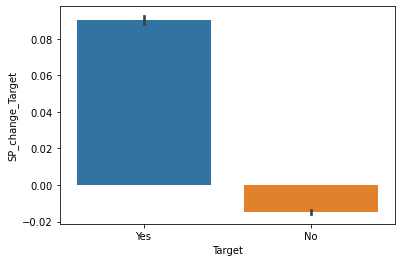

In [53]:
sns.barplot(data=ideal, y='SP_change_Target', x='Target');

In this, I would like to go further and and explore the "ideal" dataset.

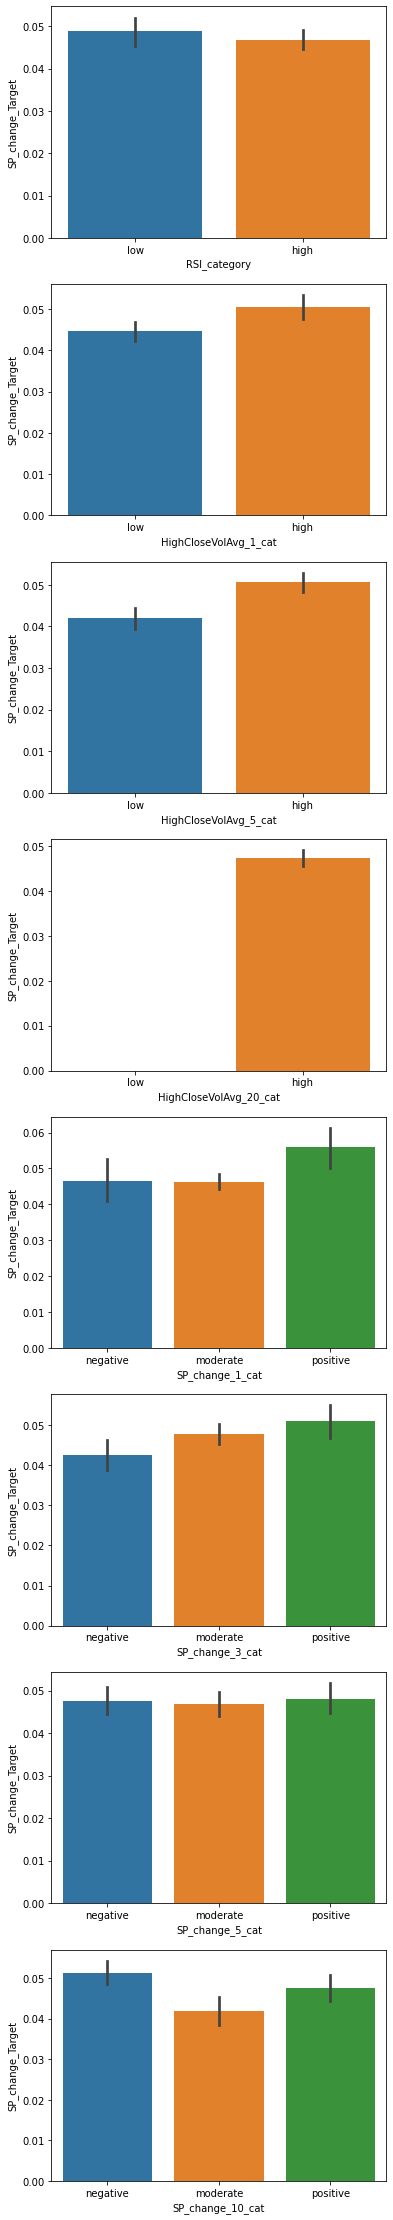

In [54]:
cats = ideal.dtypes[ideal.dtypes=='category'].index

N = len(cats)
counter = 0

fig, ax = plt.subplots(nrows=N, figsize=(6, 5*N))

for cat in cats:
    sns.barplot(data=ideal, y='SP_change_Target', x=cat, ax=ax[counter])
    counter += 1

Having a negative SP_change_10_cat seems to be the only separation here. Let's see how big that set is.

In [55]:
ideal['SP_change_10_cat'].value_counts()

negative    2449
positive    2012
moderate    1820
Name: SP_change_10_cat, dtype: int64

The sample size is2416. Compared to the original training set size of ~46000, this indicates roughly 5% of our data points meet both criteria.

In [56]:
neg_sp_change_ideal = ideal[ideal['SP_change_10_cat']=='negative']

In [57]:
neg_sp_change_ideal['SP_change_Target'].describe()

count    2449.000000
mean        0.051290
std         0.070725
min        -0.196442
25%         0.006594
50%         0.042118
75%         0.087361
max         0.403438
Name: SP_change_Target, dtype: float64

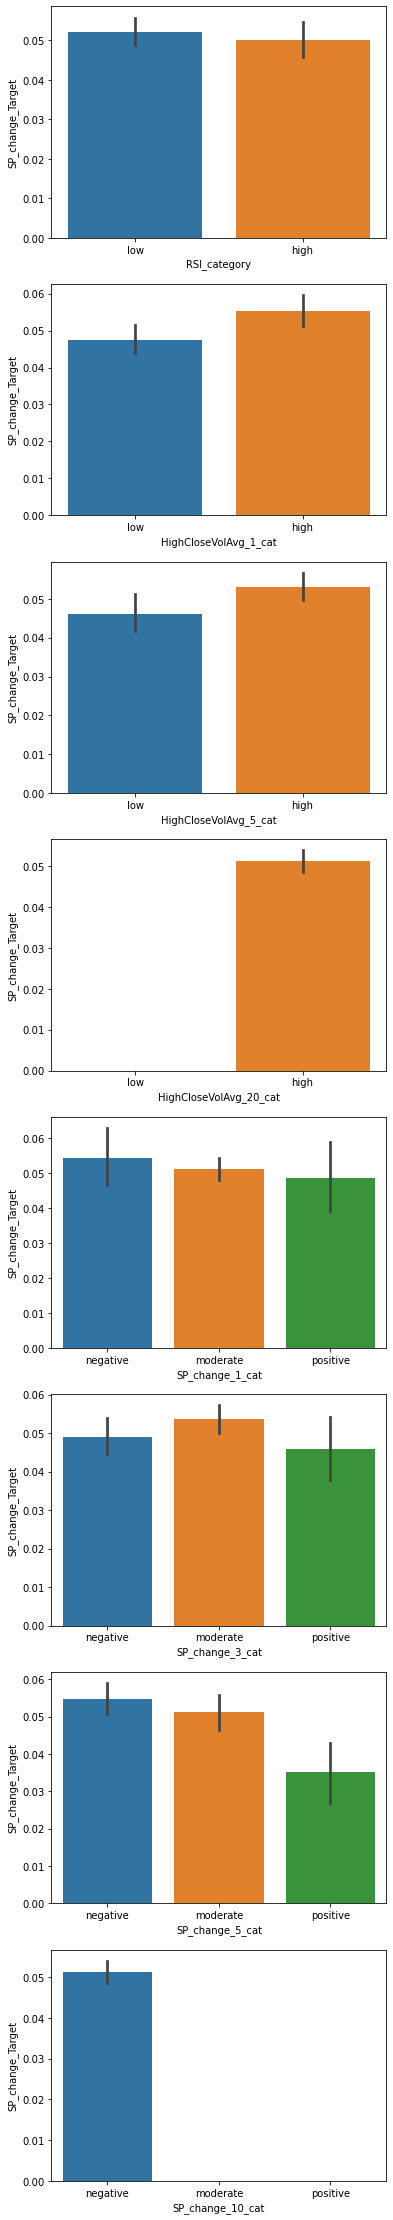

In [58]:
cats = neg_sp_change_ideal.dtypes[neg_sp_change_ideal.dtypes=='category'].index

N = len(cats)
counter = 0

fig, ax = plt.subplots(nrows=N, figsize=(6, 5*N))

for cat in cats:
    sns.barplot(data=neg_sp_change_ideal, y='SP_change_Target', x=cat, ax=ax[counter])
    counter += 1

Since there is no clear separation above and we are already down to 5% of the original data, I do not want to go through any more. I will now see how the test set stacks up with these same restrictions.

In [59]:
test_restriction = test[(test['HighCloseVolAvg_20']>=0.03) & (test['SP_change_10']<=-0.05)]

In [60]:
test_restriction.shape

(269, 10)

In [61]:
test.shape

(5122, 10)

<AxesSubplot:ylabel='SP_change_Target'>

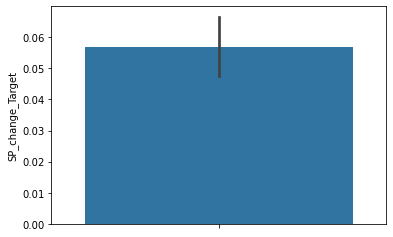

In [62]:
sns.barplot(data=test_restriction, y='SP_change_Target')

In [63]:
test_restriction['SP_change_Target'].describe()

count    269.000000
mean       0.056876
std        0.076097
min       -0.101897
25%        0.004819
50%        0.045911
75%        0.098142
max        0.352279
Name: SP_change_Target, dtype: float64

In [64]:
from scipy import stats

In [65]:
std_err = stats.sem(test_restriction['SP_change_Target'])
mean = np.mean(test_restriction['SP_change_Target'])

stats.norm.interval(0.95, loc=mean, scale=std_err)

(0.04778232725717898, 0.06596970536437693)

In [77]:
# see how the entire data set works on with these conditions now.

restricted = df[(df['HighCloseVolAvg_20']>=0.03)&(df['SP_change_10']<=-0.05)]

data = restricted['SP_change_Target']

std_err = stats.sem(data)
mean = np.mean(data)

print(stats.norm.interval(0.95, loc=mean, scale=std_err))

(0.049162742293752185, 0.05452215852956173)


In [80]:
restricted.shape[0]

2718

By limiting to these two conditions, the 95% confidence interval on the test data is roughly between 4.9% and 5.4%.

I will compare how this does to the models to see if it is worth performing a model or just restricting to these two conditions.